## Introduction to the dataset

- World Health Organization has  estimated 12 million deaths occur worldwide, every year due to Heart diseases.

- Half the deaths in the United States and other developed countries are due to cardio vascular diseases. 

- The early prognosis of cardiovascular diseases can aid in making decisions on lifestyle changes in high risk patients and in turn reduce the complications.

- This research intends to pinpoint the most relevant/risk factors of heart disease as well as predict the overall risk using logistic regression.


In [1]:
import math
from collections import Counter

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats as st
import seaborn as sns
import statsmodels.api as sm
from sklearn.metrics import (ConfusionMatrixDisplay, accuracy_score,
                             classification_report, confusion_matrix, f1_score,
                             mean_squared_error, precision_score, recall_score,
                             roc_auc_score)
from sklearn.preprocessing import Binarizer, LabelEncoder, StandardScaler
from statsmodels.tools import add_constant as ac

sc = StandardScaler()
le = LabelEncoder()

from collections import Counter

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as imbpipeline
from imblearn.pipeline import make_pipeline as imbalanced_make_pipeline
from imblearn.under_sampling import NearMiss
from sklearn.ensemble import (AdaBoostClassifier, BaggingClassifier,
                              RandomForestClassifier, StackingClassifier)
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import (GridSearchCV, KFold, RandomizedSearchCV,
                                     StratifiedKFold, cross_val_score,
                                     train_test_split)
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import make_pipeline
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

rfc = RandomForestClassifier()
import warnings

warnings.filterwarnings('ignore')

In [2]:
data = pd.read_csv('./Data/US_Heart_Patients.csv')
data.head()

,male,age,education,currentSmoker,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose,TenYearCHD
0,1,39,4.0,0,0.0,0.0,0,0,0,195.0,106.0,70.0,26.97,80.0,77.0,0
1,0,46,2.0,0,0.0,0.0,0,0,0,250.0,121.0,81.0,28.73,95.0,76.0,0
2,1,48,1.0,1,20.0,0.0,0,0,0,245.0,127.5,80.0,25.34,75.0,70.0,0
3,0,61,3.0,1,30.0,0.0,0,1,0,225.0,150.0,95.0,28.58,65.0,103.0,1
4,0,46,3.0,1,23.0,0.0,0,0,0,285.0,130.0,84.0,23.10,85.0,85.0,0


In [3]:
data.shape

(4240, 16)

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4240 entries, 0 to 4239
Data columns (total 16 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   male             4240 non-null   int64  
 1   age              4240 non-null   int64  
 2   education        4135 non-null   float64
 3   currentSmoker    4240 non-null   int64  
 4   cigsPerDay       4211 non-null   float64
 5   BPMeds           4187 non-null   float64
 6   prevalentStroke  4240 non-null   int64  
 7   prevalentHyp     4240 non-null   int64  
 8   diabetes         4240 non-null   int64  
 9   totChol          4190 non-null   float64
 10  sysBP            4240 non-null   float64
 11  diaBP            4240 non-null   float64
 12  BMI              4221 non-null   float64
 13  heartRate        4239 non-null   float64
 14  glucose          3852 non-null   float64
 15  TenYearCHD       4240 non-null   int64  
dtypes: float64(9), int64(7)
memory usage: 530.1 KB


In [5]:
target_var = 'TenYearCHD'

In [6]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
male,4240.0,0.429245,0.495027,0.00,0.00,0.0,1.00,1.0
age,4240.0,49.580189,8.572942,32.00,42.00,49.0,56.00,70.0
education,4135.0,1.979444,1.019791,1.00,1.00,2.0,3.00,4.0
currentSmoker,4240.0,0.494104,0.500024,0.00,0.00,0.0,1.00,1.0
cigsPerDay,4211.0,9.005937,11.922462,0.00,0.00,0.0,20.00,70.0
BPMeds,4187.0,0.029615,0.169544,0.00,0.00,0.0,0.00,1.0
prevalentStroke,4240.0,0.005896,0.076569,0.00,0.00,0.0,0.00,1.0
prevalentHyp,4240.0,0.310613,0.462799,0.00,0.00,0.0,1.00,1.0
diabetes,4240.0,0.025708,0.158280,0.00,0.00,0.0,0.00,1.0
totChol,4190.0,236.699523,44.591284,107.00,206.00,234.0,263.00,696.0


In [7]:
# Check Multicollinearilty

def check_multicol(x):
    plt.figure(figsize=(20, 10))
    sns.heatmap(x.corr(), annot=True)
    plt.show()

In [8]:
def split_data(df, tar = target_var, val = 'no'):
    x = df.loc[:, df.columns != tar]
    y = df.loc[:, tar]
    
    return x, y

###  EDA and Feature Engineering

#### Univariate Analysis

In [9]:
data.head()

,male,age,education,currentSmoker,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose,TenYearCHD
0,1,39,4.0,0,0.0,0.0,0,0,0,195.0,106.0,70.0,26.97,80.0,77.0,0
1,0,46,2.0,0,0.0,0.0,0,0,0,250.0,121.0,81.0,28.73,95.0,76.0,0
2,1,48,1.0,1,20.0,0.0,0,0,0,245.0,127.5,80.0,25.34,75.0,70.0,0
3,0,61,3.0,1,30.0,0.0,0,1,0,225.0,150.0,95.0,28.58,65.0,103.0,1
4,0,46,3.0,1,23.0,0.0,0,0,0,285.0,130.0,84.0,23.10,85.0,85.0,0


In [10]:
# Converting object and numerical to category

to_be_cat = ['male', 'education', 'currentSmoker', 'BPMeds', 'prevalentStroke', 'prevalentHyp', 'diabetes', 'TenYearCHD']
data[to_be_cat]= data[to_be_cat].astype('category')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4240 entries, 0 to 4239
Data columns (total 16 columns):
 #   Column           Non-Null Count  Dtype   
---  ------           --------------  -----   
 0   male             4240 non-null   category
 1   age              4240 non-null   int64   
 2   education        4135 non-null   category
 3   currentSmoker    4240 non-null   category
 4   cigsPerDay       4211 non-null   float64 
 5   BPMeds           4187 non-null   category
 6   prevalentStroke  4240 non-null   category
 7   prevalentHyp     4240 non-null   category
 8   diabetes         4240 non-null   category
 9   totChol          4190 non-null   float64 
 10  sysBP            4240 non-null   float64 
 11  diaBP            4240 non-null   float64 
 12  BMI              4221 non-null   float64 
 13  heartRate        4239 non-null   float64 
 14  glucose          3852 non-null   float64 
 15  TenYearCHD       4240 non-null   category
dtypes: category(8), float64(7), int64(1)
memor

In [11]:
data.head()

,male,age,education,currentSmoker,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose,TenYearCHD
0,1,39,4.0,0,0.0,0.0,0,0,0,195.0,106.0,70.0,26.97,80.0,77.0,0
1,0,46,2.0,0,0.0,0.0,0,0,0,250.0,121.0,81.0,28.73,95.0,76.0,0
2,1,48,1.0,1,20.0,0.0,0,0,0,245.0,127.5,80.0,25.34,75.0,70.0,0
3,0,61,3.0,1,30.0,0.0,0,1,0,225.0,150.0,95.0,28.58,65.0,103.0,1
4,0,46,3.0,1,23.0,0.0,0,0,0,285.0,130.0,84.0,23.10,85.0,85.0,0


In [12]:
not_to_plot = [] # contains column names which are not to be plotted. In this case we have none.
color = ['red', 'blue', 'green']

In [13]:
def univariate(df = data, rows = 4, cols = 4):
    k = 0
    fig=plt.figure(figsize=(20,20))
    for i in df.columns:
        if i not in not_to_plot:
            # ax=fig.add_subplot(rows,cols,k+1)
            if i in df.select_dtypes(['category', 'object']):
                ax=fig.add_subplot(rows,cols,k+1)
                sns.countplot(x= i, data = df, ax=ax)
                k += 1
            if i in df.select_dtypes(['int', 'float64']):
                ax=fig.add_subplot(rows,cols,k+1)
                sns.distplot(x = df[i], ax=ax, color=np.random.choice(color))
                ax.set(xlabel=i)
                k += 1
    fig.tight_layout() 
    plt.show()

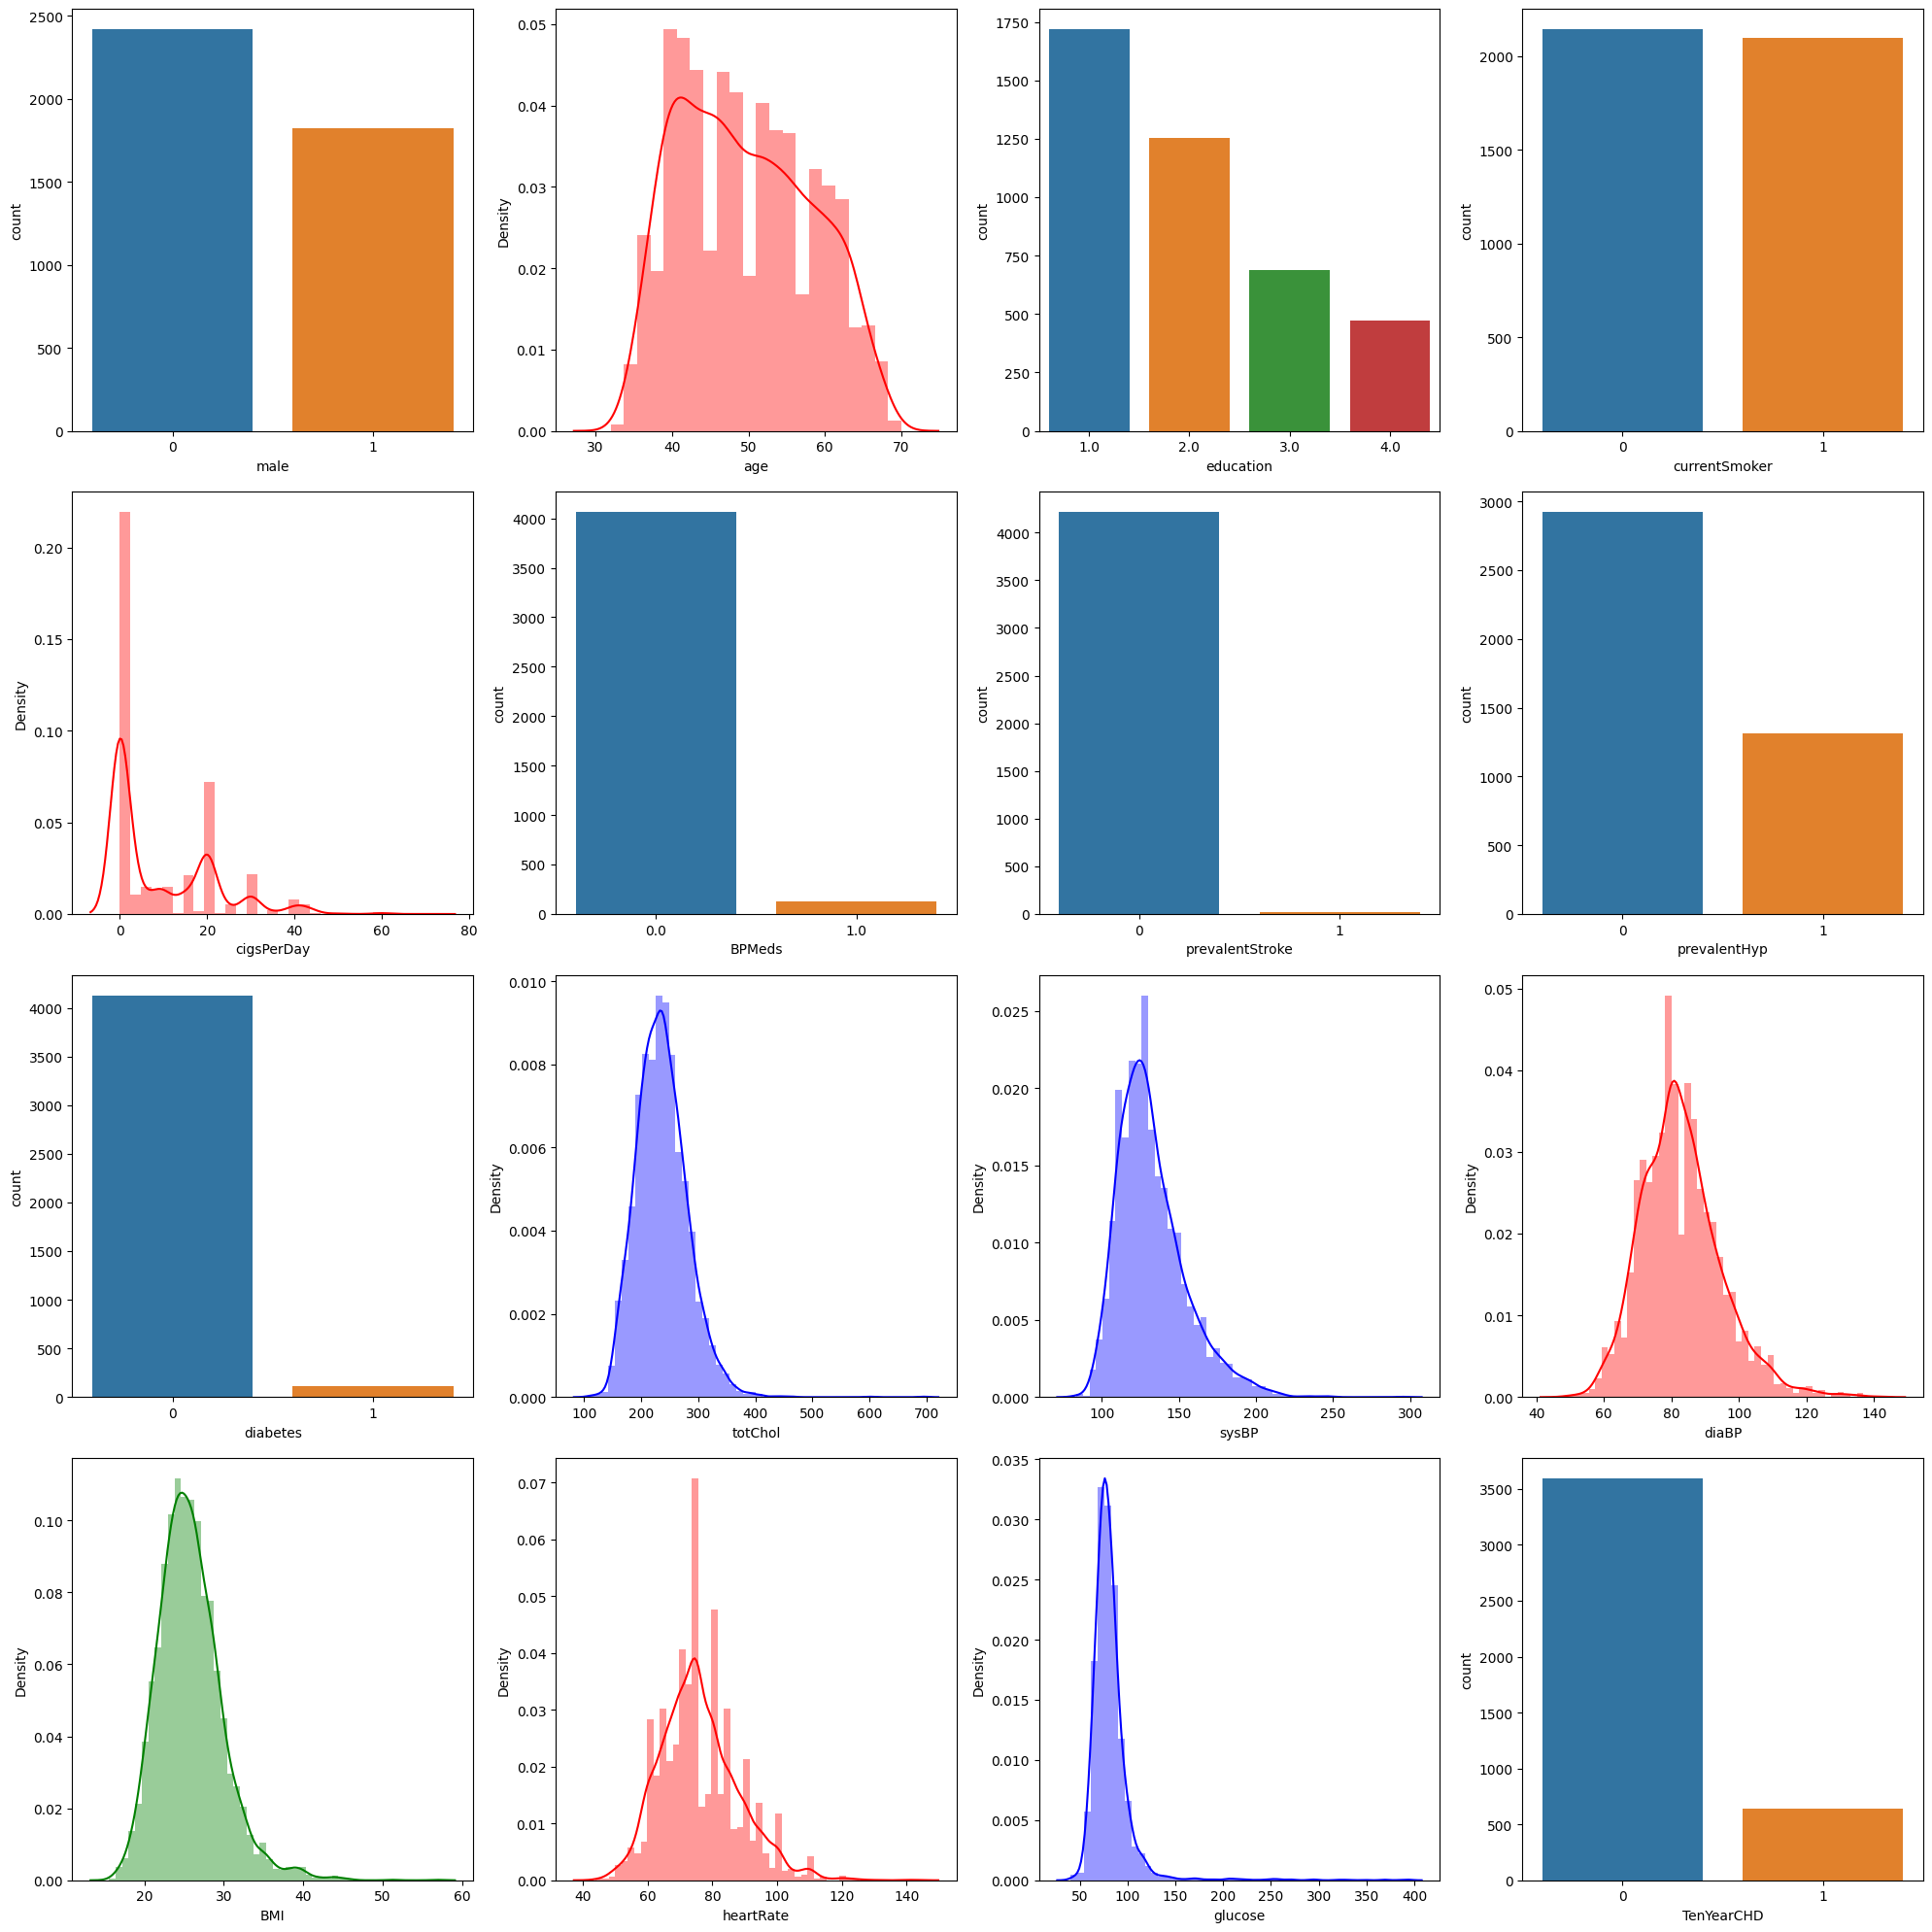

In [14]:
univariate(data)

#### Bivariate Analysis

In [15]:
def bivariate(df = data, y = target_var, cols = 3, rows = 5):
    temp = not_to_plot[:]
    temp.append(y)
    k = 0
    fig=plt.figure(figsize=(25,20))

    for i in df.columns:
        if i not in temp:
            if y in df.select_dtypes(['float', 'int']):
                if i in df.select_dtypes(['category', 'object']):
                    if (i not in temp): 
                        ax=fig.add_subplot(rows,cols,k+1)
                        sns.boxplot(x = i, y = y, data = df)

                if i in df.select_dtypes(['float', 'int']):                
                    if (i not in temp):      
                        ax=fig.add_subplot(rows,cols,k+1)       
                        sns.scatterplot(x = y, y = i, data = df)                  
                k += 1
            elif y in df.select_dtypes(['category', 'object']):
                if i in df.select_dtypes(['category', 'object']):
                    if (i not in temp):
                        ax=fig.add_subplot(rows,cols,k+1)
                        sns.countplot(x = i, hue = y, data = df)
                        plt.legend(bbox_to_anchor=(1, 1), loc=2, borderaxespad=0.)

                if i in df.select_dtypes(['float', 'int']):
                    if (i not in temp):
                        ax=fig.add_subplot(rows,cols,k+1)
                        sns.boxplot(x = y, y = i, data = df)
                k += 1
    fig.tight_layout() 
    plt.show()

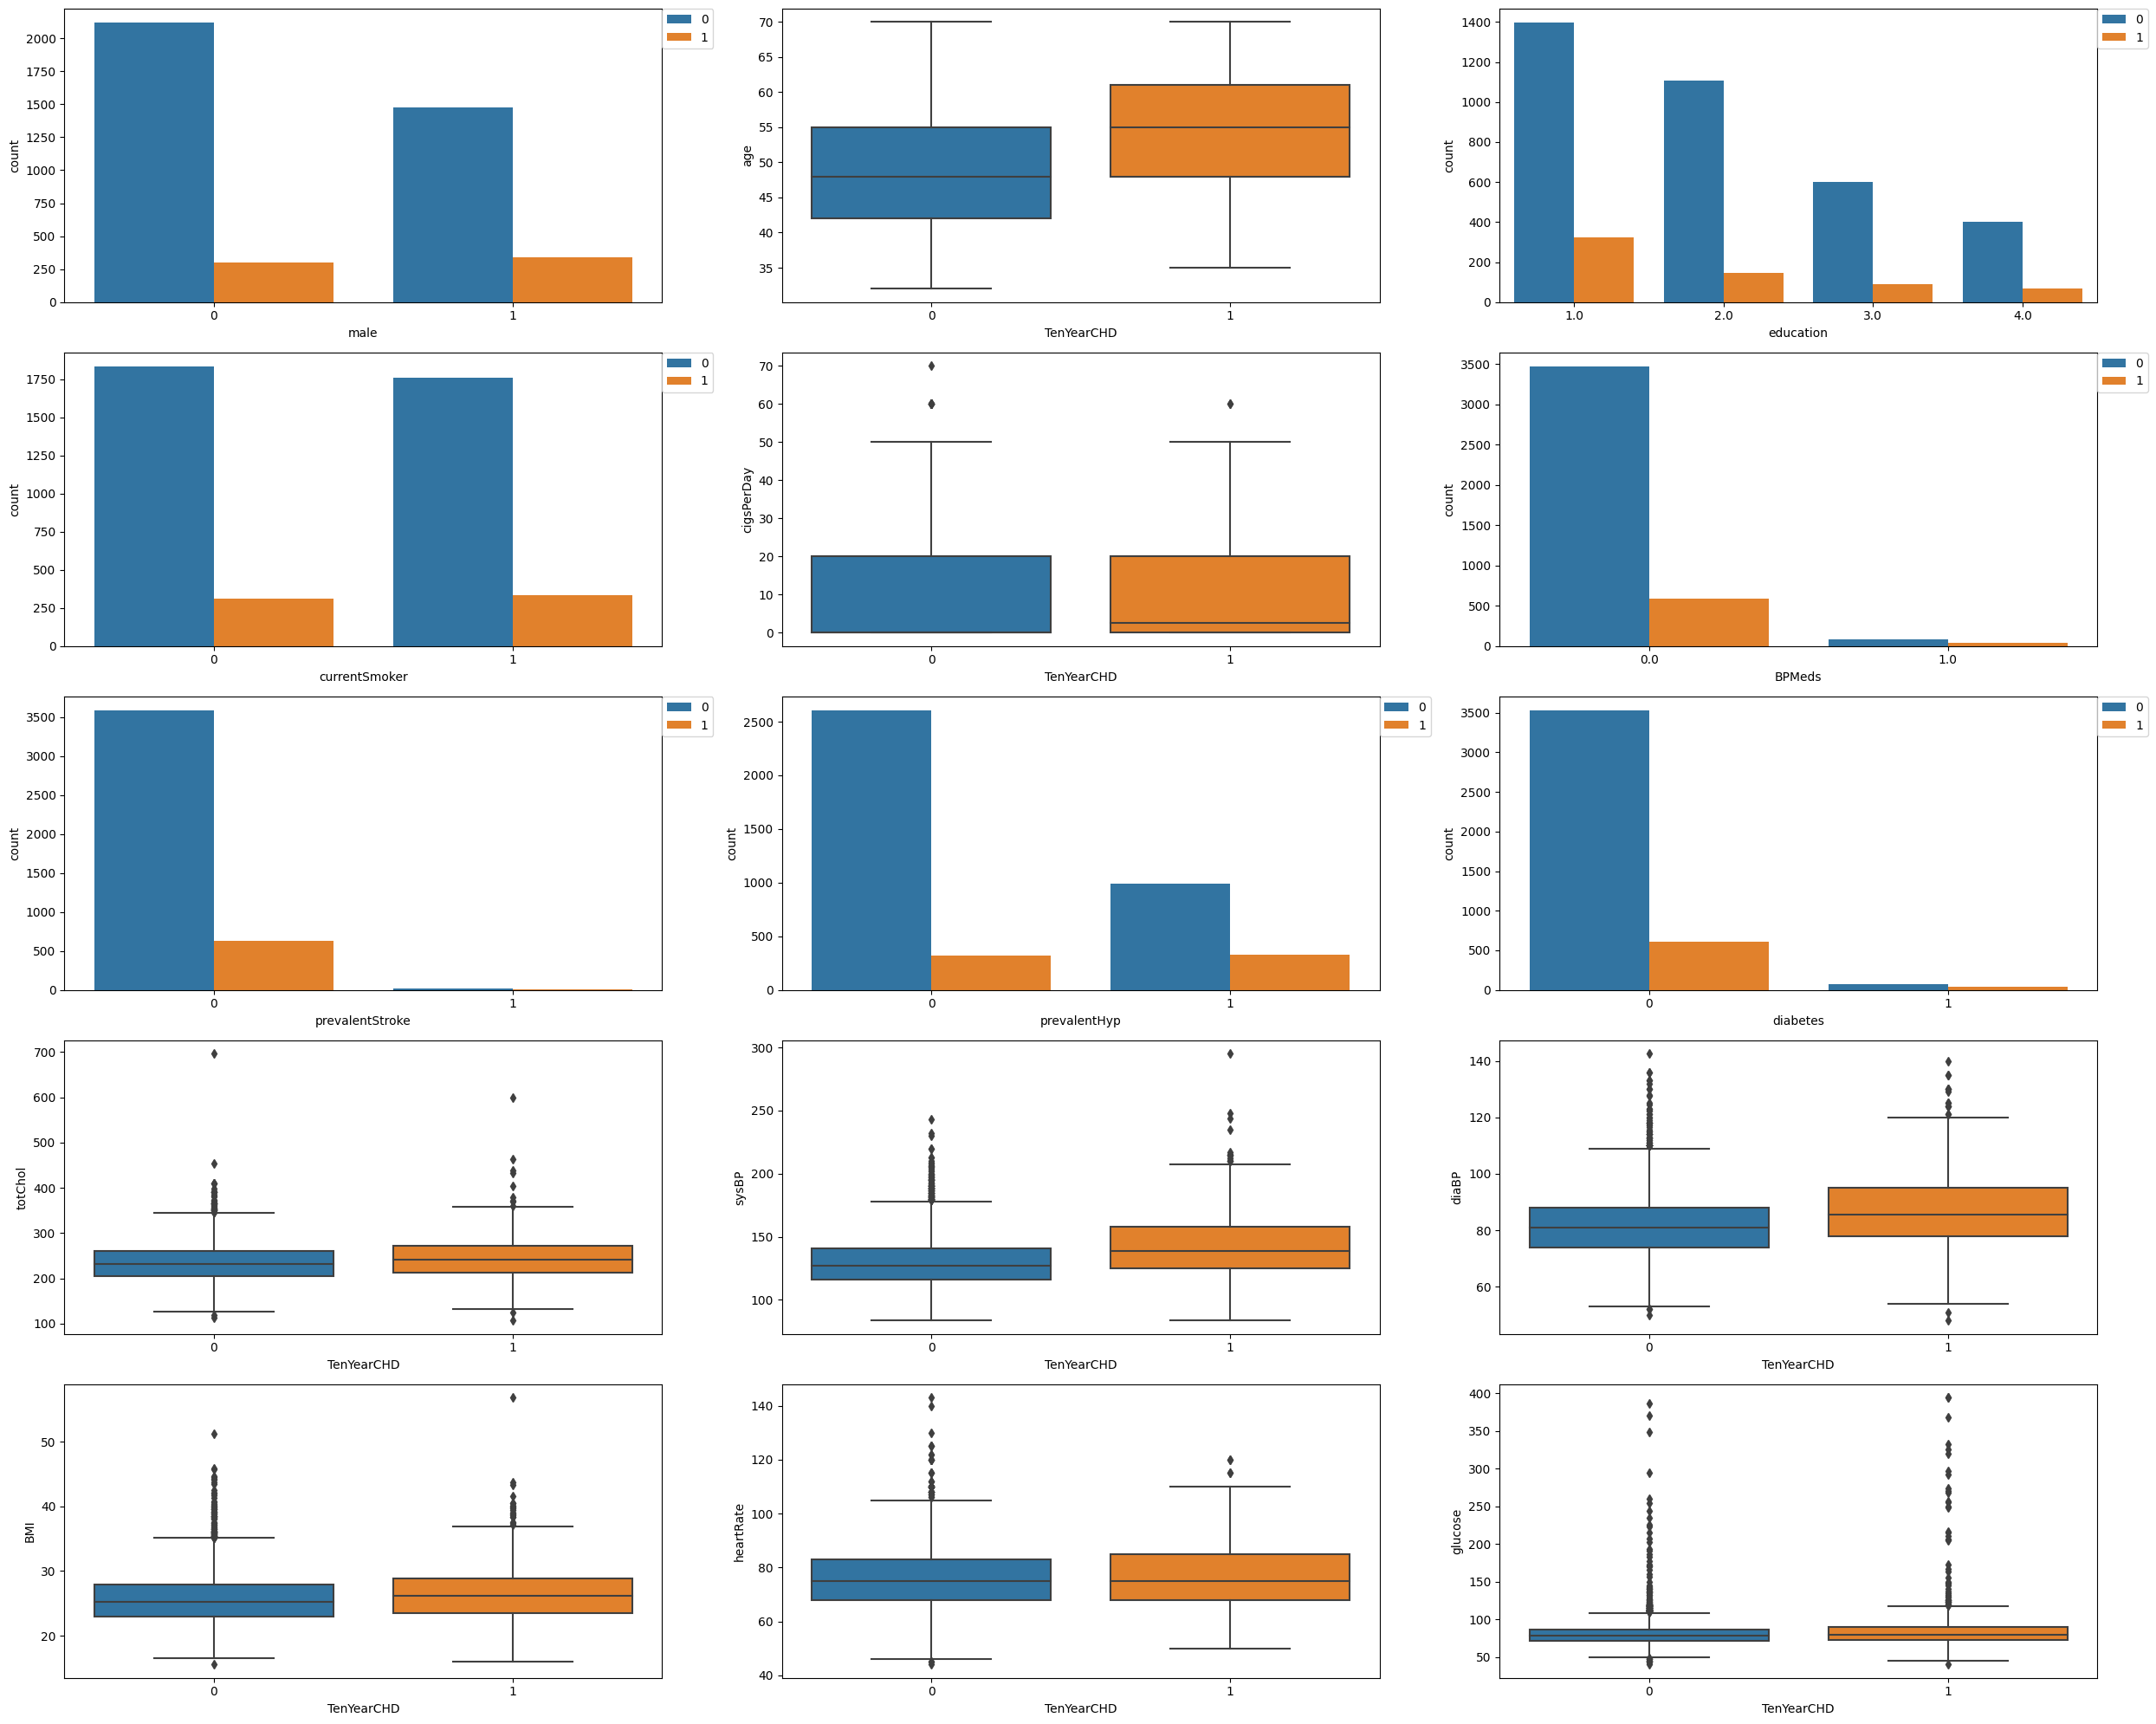

In [16]:
bivariate()

#### Missing Values

In [17]:
data.isnull().sum()

male                 0
age                  0
education          105
currentSmoker        0
cigsPerDay          29
BPMeds              53
prevalentStroke      0
prevalentHyp         0
diabetes             0
totChol             50
sysBP                0
diaBP                0
BMI                 19
heartRate            1
glucose            388
TenYearCHD           0
dtype: int64

In [18]:
# % of all missing var
miss_df = pd.DataFrame(data.isnull().sum(), columns=['Miss_Values'])
for i in miss_df.index:
    val = miss_df._get_value(i, miss_df.columns[0]) 
    if val > 0:
        print(i, "% : ", val*100/data.shape[0])
        

education % :  2.4764150943396226
cigsPerDay % :  0.6839622641509434
BPMeds % :  1.25
totChol % :  1.179245283018868
BMI % :  0.4481132075471698
heartRate % :  0.02358490566037736
glucose % :  9.150943396226415


In [19]:
data.drop(['education', 'glucose'], axis = 1, inplace = True)

In [20]:
data.isnull().sum()

male                0
age                 0
currentSmoker       0
cigsPerDay         29
BPMeds             53
prevalentStroke     0
prevalentHyp        0
diabetes            0
totChol            50
sysBP               0
diaBP               0
BMI                19
heartRate           1
TenYearCHD          0
dtype: int64

In [21]:
# Case 1: Drop All Null Values.
data.dropna(inplace=True)
data.isnull().sum()

male               0
age                0
currentSmoker      0
cigsPerDay         0
BPMeds             0
prevalentStroke    0
prevalentHyp       0
diabetes           0
totChol            0
sysBP              0
diaBP              0
BMI                0
heartRate          0
TenYearCHD         0
dtype: int64

In [22]:
data.head()

,male,age,currentSmoker,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,TenYearCHD
0,1,39,0,0.0,0.0,0,0,0,195.0,106.0,70.0,26.97,80.0,0
1,0,46,0,0.0,0.0,0,0,0,250.0,121.0,81.0,28.73,95.0,0
2,1,48,1,20.0,0.0,0,0,0,245.0,127.5,80.0,25.34,75.0,0
3,0,61,1,30.0,0.0,0,1,0,225.0,150.0,95.0,28.58,65.0,1
4,0,46,1,23.0,0.0,0,0,0,285.0,130.0,84.0,23.10,85.0,0


In [23]:
data[['cigsPerDay']] = data[['cigsPerDay']].astype('int64')

In [24]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4090 entries, 0 to 4239
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype   
---  ------           --------------  -----   
 0   male             4090 non-null   category
 1   age              4090 non-null   int64   
 2   currentSmoker    4090 non-null   category
 3   cigsPerDay       4090 non-null   int64   
 4   BPMeds           4090 non-null   category
 5   prevalentStroke  4090 non-null   category
 6   prevalentHyp     4090 non-null   category
 7   diabetes         4090 non-null   category
 8   totChol          4090 non-null   float64 
 9   sysBP            4090 non-null   float64 
 10  diaBP            4090 non-null   float64 
 11  BMI              4090 non-null   float64 
 12  heartRate        4090 non-null   float64 
 13  TenYearCHD       4090 non-null   category
dtypes: category(7), float64(5), int64(2)
memory usage: 284.4 KB


#### Encoding Data

In [25]:
lb_data = data.apply(LabelEncoder().fit_transform) #type: ignore

In [26]:
def encod_data(df):
    cols = df.select_dtypes('category').columns
    cols = list(cols)
    cols.remove('TenYearCHD')

    df = pd.get_dummies(df, columns = cols, drop_first=True)

    return df

In [27]:
en_data = encod_data(data)
en_data.head()

,age,cigsPerDay,totChol,sysBP,diaBP,BMI,heartRate,TenYearCHD,male_1,currentSmoker_1,BPMeds_1.0,prevalentStroke_1,prevalentHyp_1,diabetes_1
0,39,0,195.0,106.0,70.0,26.97,80.0,0,1,0,0,0,0,0
1,46,0,250.0,121.0,81.0,28.73,95.0,0,0,0,0,0,0,0
2,48,20,245.0,127.5,80.0,25.34,75.0,0,1,1,0,0,0,0
3,61,30,225.0,150.0,95.0,28.58,65.0,1,0,1,0,0,1,0
4,46,23,285.0,130.0,84.0,23.10,85.0,0,0,1,0,0,0,0


#### Model Building

##### 1. Logistic Regression

In [28]:
# Implementing SMOTE

def smote(x, y):
    oversample = SMOTE(random_state = 2, sampling_strategy='minority')

    x = x.values
    y = y.values
    
    x, y = oversample.fit_resample(x, y)  #type: ignore
    return x, y

In [29]:
def create_cm(model, tup):
    x, xv, y, yv = tup[0], tup[1], tup[2], tup[3]

    model.fit(x, y)
    yp = model.predict(xv)
    
    cm = confusion_matrix(yv, yp)
    cm_df = pd.DataFrame(cm, columns=['Pred: 0', 'Pred: 1'], index = ['Obs: 0', 'Obs: 1'])

    sns.heatmap(cm_df, annot=True, fmt='d')
    plt.show()
    
    print(classification_report(yv, yp))

In [30]:
# General Grid Search Model that could be used by all Classification Models. 

def rand_search(model, params, df = en_data, cm = 'no'):
    x, y = split_data(df)

    x, y = smote(x, y)

    x_train, x_val, y_train, y_val = train_test_split(x, y, test_size = 0.3, random_state = 123)
    
    print(Counter(y_train))
    
    x_train = sc.fit_transform(x_train)
    x_val = sc.transform(x_val)

    grid_mod = RandomizedSearchCV(model, param_distributions=params, scoring = ['accuracy'], cv = 10, n_jobs=10, refit='accuracy') # type: ignore    
    grid_mod.fit(x_train, y_train)

    if cm == 'yes':
        create_cm(grid_mod.best_estimator_, (x_train, x_val, y_train, y_val))

    return grid_mod.best_estimator_, grid_mod.best_score_

In [31]:
x, y = split_data(lb_data)

model = sm.Logit(y, ac(x))
res = model.fit()

print(res.summary())

Optimization terminated successfully.
         Current function value: 0.375018
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:             TenYearCHD   No. Observations:                 4090
Model:                          Logit   Df Residuals:                     4076
Method:                           MLE   Df Model:                           13
Date:                Fri, 27 Jan 2023   Pseudo R-squ.:                  0.1106
Time:                        21:27:55   Log-Likelihood:                -1533.8
converged:                       True   LL-Null:                       -1724.5
Covariance Type:            nonrobust   LLR p-value:                 1.863e-73
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
const              -4.4643      0.261    -17.099      0.000      -4.976      -3.953
male          

In [32]:
# Removing cols with p-value more than 0.05

def back_feat_elem(df = data, tar = target_var):
    x, y = split_data(lb_data)
    
    col = x.columns

    while len(col) > 0:
        model = sm.Logit(y, ac(x[col]))
        result = model.fit(disp= 0)
        largest_pvalue = round(result.pvalues, 3).nlargest(1)
        if largest_pvalue[0] < (0.05):
            return result
            break
        else:
            col = col.drop(largest_pvalue.index)  

In [33]:
back_res = back_feat_elem()
back_res.summary()  #type: ignore

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:             TenYearCHD   No. Observations:                 4090
Model:                          Logit   Df Residuals:                     4084
Method:                           MLE   Df Model:                            5
Date:                Fri, 27 Jan 2023   Pseudo R-squ.:                  0.1080
Time:                        21:27:56   Log-Likelihood:                -1538.3
converged:                       True   LL-Null:                       -1724.5
Covariance Type:            nonrobust   LLR p-value:                 2.451e-78
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -4.4335      0.172    -25.711      0.000      -4.771      -4.096
male           0.5164      0.099      5.197      0.000       0.322       0.711
age            0.0678      0.006     11.111      0.000       0.056       0.080
cigsPerDay     0.0281      0.005      5.609      0.000       0.018       0.038
diabetes       0.7152      0.223      3.204      0.001       0.278       1.153
sysBP          0.0094      0.001      8.679      0.000       0.007       0.012
==============================================================================
"""

In [34]:
ind = list(back_res.params.index)  #type: ignore
ind.remove('const')

# To Insert Imp Cols that I like.
# ind.extend([''])

ind

['male', 'age', 'cigsPerDay', 'diabetes', 'sysBP']

In [36]:
new_x = data[ind]
new_y = data.TenYearCHD
new_df = pd.concat([new_x,new_y], axis=1)
new_df.head()

,male,age,cigsPerDay,diabetes,sysBP,TenYearCHD
0,1,39,0,0,106.0,0
1,0,46,0,0,121.0,0
2,1,48,20,0,127.5,0
3,0,61,30,0,150.0,1
4,0,46,23,0,130.0,0


In [37]:
new_en_data = encod_data(new_df)
new_en_data.head()

,age,cigsPerDay,sysBP,TenYearCHD,male_1,diabetes_1
0,39,0,106.0,0,1,0
1,46,0,121.0,0,0,0
2,48,20,127.5,0,1,0
3,61,30,150.0,1,0,0
4,46,23,130.0,0,0,0


In [38]:
new_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4090 entries, 0 to 4239
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   male        4090 non-null   category
 1   age         4090 non-null   int64   
 2   cigsPerDay  4090 non-null   int64   
 3   diabetes    4090 non-null   category
 4   sysBP       4090 non-null   float64 
 5   TenYearCHD  4090 non-null   category
dtypes: category(3), float64(1), int64(2)
memory usage: 140.2 KB


In [39]:
new_en_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4090 entries, 0 to 4239
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   age         4090 non-null   int64   
 1   cigsPerDay  4090 non-null   int64   
 2   sysBP       4090 non-null   float64 
 3   TenYearCHD  4090 non-null   category
 4   male_1      4090 non-null   uint8   
 5   diabetes_1  4090 non-null   uint8   
dtypes: category(1), float64(1), int64(2), uint8(2)
memory usage: 139.9 KB


In [40]:
params_lg = {
    'penalty': ['l1', 'l2','elasticnet'],
    'tol': [0.1, 0.01],
    'C': [0.1, 0.01],
    'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
    'max_iter': [10, 100],
    'multi_class': ['auto', 'ovr','multinomial'],
    'n_jobs': [3,4],
}

In [41]:
en_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4090 entries, 0 to 4239
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype   
---  ------             --------------  -----   
 0   age                4090 non-null   int64   
 1   cigsPerDay         4090 non-null   int64   
 2   totChol            4090 non-null   float64 
 3   sysBP              4090 non-null   float64 
 4   diaBP              4090 non-null   float64 
 5   BMI                4090 non-null   float64 
 6   heartRate          4090 non-null   float64 
 7   TenYearCHD         4090 non-null   category
 8   male_1             4090 non-null   uint8   
 9   currentSmoker_1    4090 non-null   uint8   
 10  BPMeds_1.0         4090 non-null   uint8   
 11  prevalentStroke_1  4090 non-null   uint8   
 12  prevalentHyp_1     4090 non-null   uint8   
 13  diabetes_1         4090 non-null   uint8   
dtypes: category(1), float64(5), int64(2), uint8(6)
memory usage: 283.7 KB


Counter({1: 2449, 0: 2421})


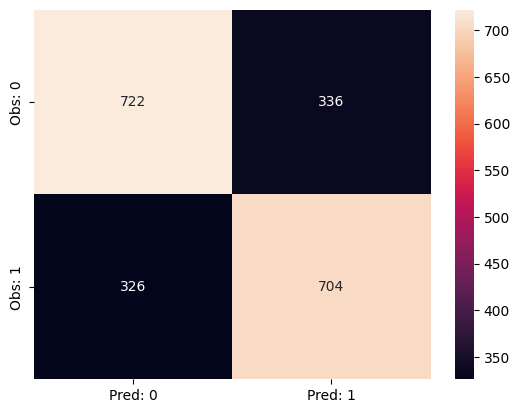

              precision    recall  f1-score   support

           0       0.69      0.68      0.69      1058
           1       0.68      0.68      0.68      1030

    accuracy                           0.68      2088
   macro avg       0.68      0.68      0.68      2088
weighted avg       0.68      0.68      0.68      2088



In [42]:
mod_lg_o, acc_lg_o = rand_search(model = LogisticRegression(), params =  params_lg, df = en_data, cm='yes')

Counter({1: 2449, 0: 2421})


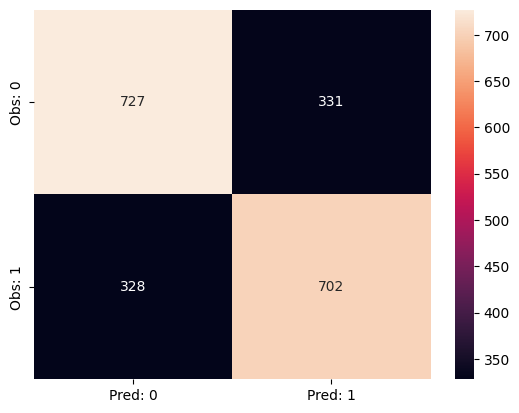

              precision    recall  f1-score   support

           0       0.69      0.69      0.69      1058
           1       0.68      0.68      0.68      1030

    accuracy                           0.68      2088
   macro avg       0.68      0.68      0.68      2088
weighted avg       0.68      0.68      0.68      2088



In [43]:
mod_lg_n, acc_lg_n = rand_search(model = LogisticRegression(), params =  params_lg, df = new_en_data, cm='yes')

The Accuracy is very low, So lets try other models.

##### 2: Decision Tree Classifier

In [44]:
new_en_data.TenYearCHD = new_en_data.TenYearCHD.astype('category')
new_en_data.TenYearCHD.dtype

CategoricalDtype(categories=[0, 1], ordered=False)

In [45]:
params_dt = {
    'criterion': ['gini','entropy', 'log_loss'],
    'splitter': ['best', 'random'],
    'max_depth': [3, 6, 9],
    'min_samples_leaf': [5, 8, 11],
    'max_features': ['sqrt', 'log2'],
}

Counter({1: 2449, 0: 2421})


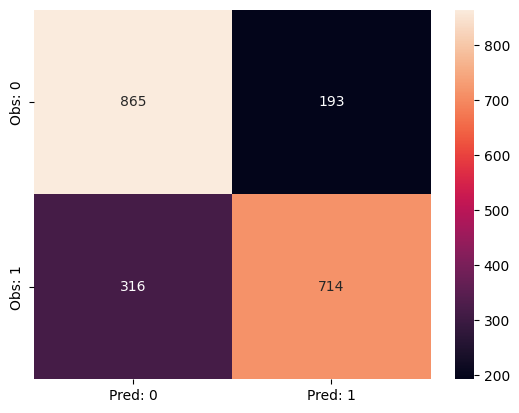

              precision    recall  f1-score   support

           0       0.73      0.82      0.77      1058
           1       0.79      0.69      0.74      1030

    accuracy                           0.76      2088
   macro avg       0.76      0.76      0.75      2088
weighted avg       0.76      0.76      0.76      2088



In [46]:
mod_dt_o, acc_dt_o = rand_search(model = DecisionTreeClassifier(), params = params_dt, df = en_data, cm='yes')

Counter({1: 2449, 0: 2421})


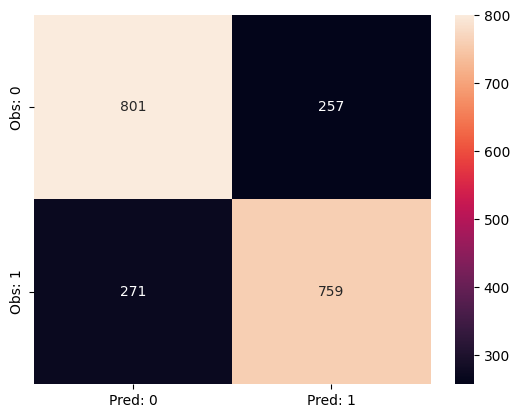

              precision    recall  f1-score   support

           0       0.75      0.76      0.75      1058
           1       0.75      0.74      0.74      1030

    accuracy                           0.75      2088
   macro avg       0.75      0.75      0.75      2088
weighted avg       0.75      0.75      0.75      2088



In [47]:
mod_dt_n, acc_dt_n = rand_search(model = DecisionTreeClassifier(), params = params_dt, df = new_en_data, cm='yes')

##### 3: KNN Classification

In [48]:
params_knn = {
    'n_neighbors': [1, 3, 5, 7, 9, 11],
    'weights': ['uniform', 'distance'],
    'p':[0,1,2,i]
}

Counter({1: 2449, 0: 2421})


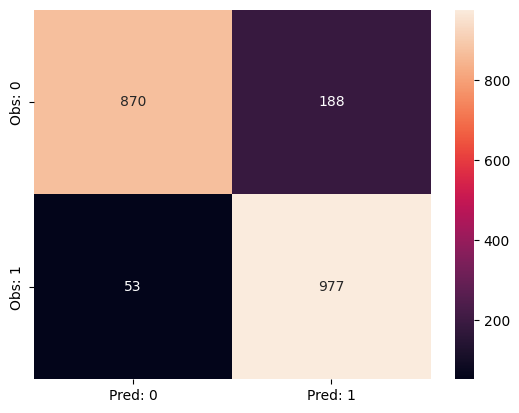

              precision    recall  f1-score   support

           0       0.94      0.82      0.88      1058
           1       0.84      0.95      0.89      1030

    accuracy                           0.88      2088
   macro avg       0.89      0.89      0.88      2088
weighted avg       0.89      0.88      0.88      2088



In [49]:
mod_knn_o, acc_knn_o = rand_search(model = KNeighborsClassifier(), params = params_knn, df = en_data, cm='yes', )

Counter({1: 2449, 0: 2421})


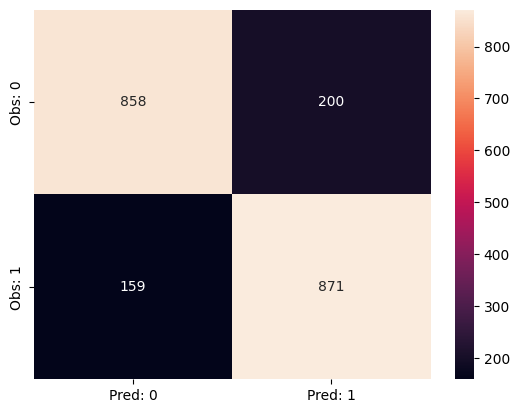

              precision    recall  f1-score   support

           0       0.84      0.81      0.83      1058
           1       0.81      0.85      0.83      1030

    accuracy                           0.83      2088
   macro avg       0.83      0.83      0.83      2088
weighted avg       0.83      0.83      0.83      2088



In [50]:
mod_knn_n, acc_knn_n = rand_search(model = KNeighborsClassifier(), params = params_knn, df = new_en_data, cm='yes', )

##### 4: SVC

In [51]:
params_svc = {
    'C': [0.1, 1, 10, 15, 20],
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
    'gamma': ['scale', 'auto'],
    'decision_function_shape': ['ovo','ovr']
}

Counter({1: 2449, 0: 2421})


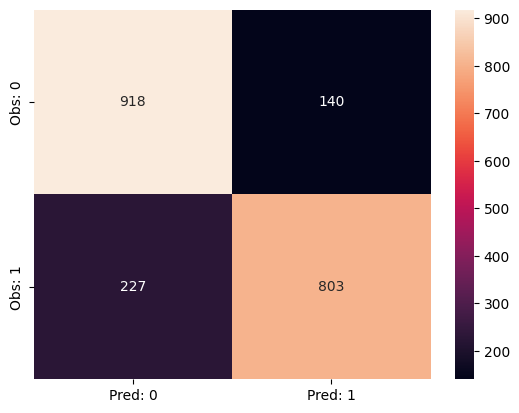

              precision    recall  f1-score   support

           0       0.80      0.87      0.83      1058
           1       0.85      0.78      0.81      1030

    accuracy                           0.82      2088
   macro avg       0.83      0.82      0.82      2088
weighted avg       0.83      0.82      0.82      2088



In [52]:
mod_svc_o, svc_acc_o = rand_search(model = SVC(), params = params_svc, df = en_data, cm='yes')

Counter({1: 2449, 0: 2421})


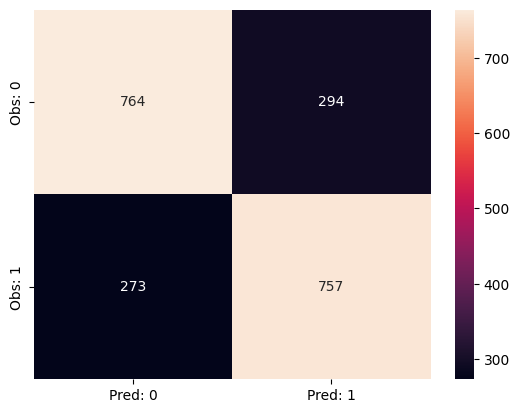

              precision    recall  f1-score   support

           0       0.74      0.72      0.73      1058
           1       0.72      0.73      0.73      1030

    accuracy                           0.73      2088
   macro avg       0.73      0.73      0.73      2088
weighted avg       0.73      0.73      0.73      2088



In [53]:
mod_svc_n, svc_acc_n = rand_search(model = SVC(), params = params_svc, df = new_en_data, cm='yes')

##### 8: Random Forest Classifier

Using GridSearchCV for Random Forest Classifier

In [54]:
rf_params = {
    'n_estimators': [10, 50, 100, 150, 200],
    'criterion': ['gini', 'entropy', 'log_loss'],
    'max_depth': [10, 15, 20, 25, 40],
    'max_features': ['sqrt', 'log2'],
    'bootstrap': [True, False],
    'oob_score': [True],
}

Counter({1: 2449, 0: 2421})


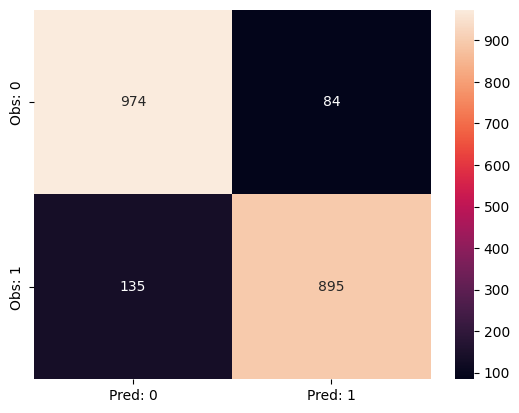

              precision    recall  f1-score   support

           0       0.88      0.92      0.90      1058
           1       0.91      0.87      0.89      1030

    accuracy                           0.90      2088
   macro avg       0.90      0.89      0.89      2088
weighted avg       0.90      0.90      0.90      2088



In [55]:
mod_rf_o, acc_rf_o = rand_search(model=RandomForestClassifier(), params=rf_params, df = en_data, cm='yes')

Counter({1: 2449, 0: 2421})


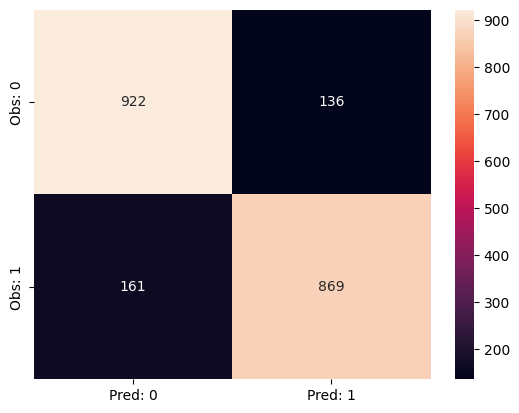

              precision    recall  f1-score   support

           0       0.85      0.87      0.86      1058
           1       0.86      0.84      0.85      1030

    accuracy                           0.86      2088
   macro avg       0.86      0.86      0.86      2088
weighted avg       0.86      0.86      0.86      2088



In [56]:
mod_rf_n, acc_rf_n = rand_search(model=RandomForestClassifier(), params=rf_params, df = new_en_data, cm='yes')

In Random Forest, the old DataFrame (data) is slightly better than the new one.

##### 9: BaggingClassifier

In [57]:
new_models = [mod_dt_n, mod_knn_n, mod_lg_n, mod_svc_n, mod_rf_n] # Models Trained on New Data
old_models = [mod_dt_o, mod_knn_o, mod_lg_o, mod_svc_o, mod_rf_o] # Models Trained on Old Data

In [58]:
params_bg_o = {
    'base_estimator': old_models,
    'n_estimators': [10, 20, 30, 40, 50],
}

Counter({1: 2449, 0: 2421})


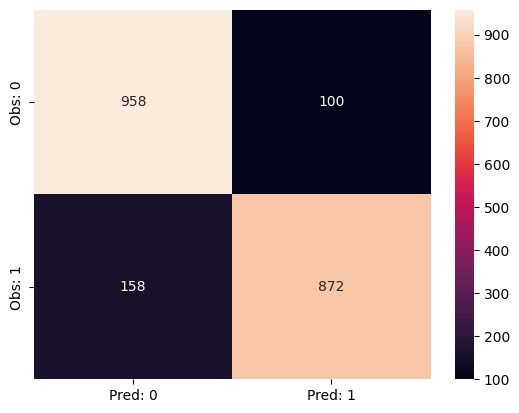

              precision    recall  f1-score   support

           0       0.86      0.91      0.88      1058
           1       0.90      0.85      0.87      1030

    accuracy                           0.88      2088
   macro avg       0.88      0.88      0.88      2088
weighted avg       0.88      0.88      0.88      2088



In [59]:
mod_bg_o, acc_bg_o = rand_search(model = BaggingClassifier(), params = params_bg_o, df = en_data, cm='yes', )

In [60]:
params_bg_n = {
    'base_estimator': new_models,
    'n_estimators': [10, 20, 30, 40, 50],
}

Counter({1: 2449, 0: 2421})


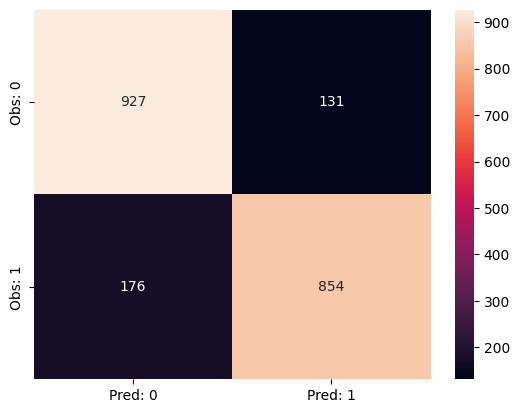

              precision    recall  f1-score   support

           0       0.84      0.88      0.86      1058
           1       0.87      0.83      0.85      1030

    accuracy                           0.85      2088
   macro avg       0.85      0.85      0.85      2088
weighted avg       0.85      0.85      0.85      2088



In [61]:
mod_bg_n, acc_bg_n = rand_search(model = BaggingClassifier(), params = params_bg_n, df = new_en_data, cm='yes')

##### 10: StackingClassifier

In [62]:
base_lv_n = []
for i in new_models:
    base_lv_n.append((str(i)[:2], i))
base_lv_n[0]

('De',
 DecisionTreeClassifier(max_depth=9, max_features='log2', min_samples_leaf=8))

In [63]:
base_lv_o = []
for i in old_models:
    base_lv_o.append((str(i)[:2], i))
base_lv_o[0]

('De',
 DecisionTreeClassifier(criterion='log_loss', max_depth=9, max_features='log2',
                        min_samples_leaf=8))

In [70]:
params_sc = {
    'cv': [5, 10, 15]
}

Counter({1: 2449, 0: 2421})


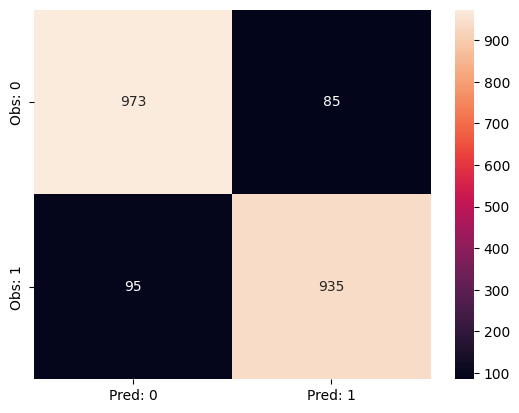

              precision    recall  f1-score   support

           0       0.91      0.92      0.92      1058
           1       0.92      0.91      0.91      1030

    accuracy                           0.91      2088
   macro avg       0.91      0.91      0.91      2088
weighted avg       0.91      0.91      0.91      2088



In [71]:
mod_sc, acc_sc = rand_search(model = StackingClassifier(estimators = base_lv_o), params = params_sc, cm = 'yes', df = en_data)

Counter({1: 2449, 0: 2421})


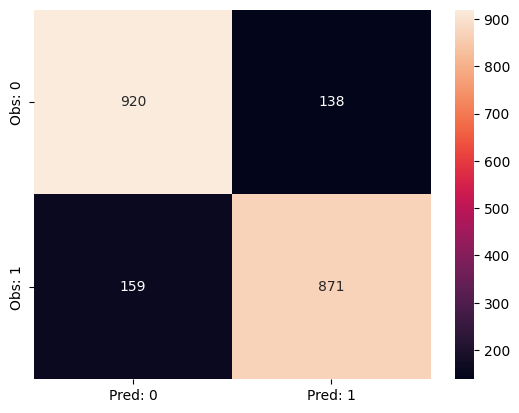

              precision    recall  f1-score   support

           0       0.85      0.87      0.86      1058
           1       0.86      0.85      0.85      1030

    accuracy                           0.86      2088
   macro avg       0.86      0.86      0.86      2088
weighted avg       0.86      0.86      0.86      2088



In [72]:
mod_sc, acc_sc = rand_search(model = StackingClassifier(estimators = base_lv_n), params = params_sc, cm = 'yes', df = new_en_data)